In [1]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
plt.ioff()
from cycler import cycler
import matplotlib.patches as mpatches
import seaborn as sns
import arviz as az
import scipy.stats as stats
#import ROOT as r
import time
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["mathtext.fontset"]="cm"
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=22
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.color']='black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'blue', 'green'])

import arviz as az
import warnings
warnings.filterwarnings('ignore')
%jsroot on

UsageError: Line magic function `%jsroot` not found.


<Figure size 432x288 with 0 Axes>

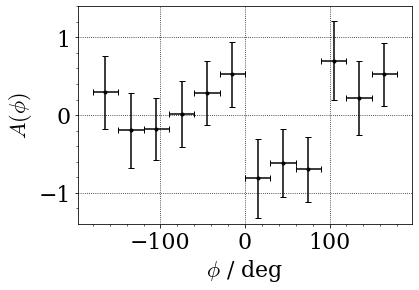

In [3]:
final_df=pd.read_csv('eta_data.csv')
i=8
j=0
x=final_df['phi']
dx=1/2*final_df['bin_phi']
y=final_df[f'A_{i,j}']
dy=final_df[f'dA_{i,j}']
fig, ax = plt.subplots()
ax.errorbar(x,y,xerr=dx,yerr=dy,fmt='.')
ax.set_xlabel("$\phi$ / deg")
ax.set_ylabel("$A(\phi)$")
ax.set_ylim([-1.4,1.4])
plt.show()

In [4]:
#this is my framework for bayesian fits and pretty plots
class bayesian_fit():
    def __init__(self,data,stanfile,nsamples=1000):
        self.data=data
        self.stan_data={'n':len(self.data['x'].values),
             'x':list(self.data['x'].values),
             'y':list(self.data['y'].values),
           'dy':list(self.data['dy'].values)}
        self.stanfile=stanfile
        self.x=self.data['x']
        self.y=self.data['y']
        self.dy=self.data['dy']
        self.model = sp.CmdStanModel(stan_file=stanfile)
        self.fitobj = self.model.sample(data=self.stan_data,iter_sampling=nsamples)
    #funtion w/o phase
    def f(self,x,a):
            return a*np.cos(2*np.pi/180.*(-45-x))
    #function with phase
    def f1(self,x,a,b,c):
            return a*np.cos(x+c)+b
    #chi2 parameters of fitted data
    def get_chisqpars(self,function):
            popt, pcov = curve_fit(function,self.data['x'].values,self.data['y'].values,
                                   sigma=self.data['dy'].values)
            return popt,pcov
    #print stan code
    def stan_code(self):
        return self.model.code()
    #get pd dataframe of samples
    def samples_df(self):
        return self.fitobj.draws_pd()
    #calculate waic for given samples and log likelihoods
    def waic(self):
        samples=self.fitobj.draws_pd()
        pwaic=np.array([np.var(samples[f'log_lik[{i+1}]'], ddof=1)for i in range(len(self.data['x']))])
        lpd=np.array([np.log(np.mean(np.exp(samples[f'log_lik[{i+1}]'])))for i in range(len(self.data['x']))])
        elpd=lpd-pwaic
        se=np.sqrt(len(self.x)*np.var(elpd,ddof=1))
        return sum(elpd), se, elpd
    #single method for pvalue
    def pval(self):
        samples=self.fitobj.draws_pd()
        y_arr=[samples[f'y_tilde[{i+1}]']for i in range(len(self.data['x']))]
        pvalue=[len([y for y in y_arr[i] if y>=self.data['y'][i]])/len(y_arr[i])for i in range(len(self.data['x']))]
        return pvalue
    #plot posterior predictive distributions
    def plot_ppd(self,save,i,j,display,fitfunc,width=.5):
        samples=self.fitobj.draws_pd()
        #cosmetics
        fig, (ax, ax1)=plt.subplots(nrows=2,sharex=True,dpi=1000,gridspec_kw={'height_ratios': [4, 1]},num=1,clear=True)
        ax.set_ylabel('$p(A_{rep}|A)$')
        ax.set_xlim([-180,180])
        ax.xaxis.set_ticks_position("top")
        ax.grid(which='minor',color='grey',lw='.4')
        #get results from chisq fit and plot them
        xx=np.linspace(np.min(self.data['x']),np.max(self.data['x']),200)
        params=self.get_chisqpars(fitfunc)[0]
        yfit=fitfunc(xx,*params)
        ax.errorbar(x=self.data['x'],y=self.data['y'],yerr=self.data['dy'],fmt='.',label='Data points')
        #ax.plot(data['x'],data['y'],'x',label='Data points')
        ax.plot(xx,yfit,'r-',label='$\chi^2$ fit',color='r')
        #violinplot for the replicated samples
        vp=ax.violinplot([samples[f'y_tilde[{i+1}]']for i in range(len(self.data['x']))],np.array(self.x),
                         showmeans=False, showextrema=False, showmedians=False,widths=width)
        #cosmetics
        for b in vp['bodies']:
            # get the center
            m = np.mean(b.get_paths()[0].vertices[:, 0])
            # modify the paths to not go further right than the center
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
            b.set_alpha(.5)
            b.set_color('red')

        #compute p value as measure of goodness of fit
        y_arr=[samples[f'y_tilde[{i+1}]']for i in range(len(self.data['x']))]
        pvalue=[len([y for y in y_arr[i] if y>=self.data['y'][i]])/len(y_arr[i])
                for i in range(len(self.data['x']))]
        pvalue_lower=[len([y for y in y_arr[i] if y-self.data['dy'][i]>=self.data['y'][i]])/len(y_arr[i])
                for i in range(len(self.data['x']))]
        pvalue_upper=[len([y for y in y_arr[i] if y+self.data['dy'][i]>=self.data['y'][i]])/len(y_arr[i])
                for i in range(len(self.data['x']))]
        pval_errors=[np.abs(np.array(pvalue_lower)-np.array(pvalue)),np.abs(np.array(pvalue_upper)-np.array(pvalue))]
        #plot pvalue
        #ax1.grid(which='minor',color='grey',lw='.4')
        ax1.errorbar(x=self.data['x'],y=pvalue,yerr=pval_errors,fmt='.')
        ax1.axhline(y=0.5, color='b', linestyle='--',label='optimal value')
        ax1.set_xlabel('$\phi$')
        ax1.set_ylabel('$T(A_{rep}>A)$')
        ax1.set_ylim([-0.1,1.1])
        #cosmetics and legend
        plt.subplots_adjust(wspace=0, hspace=0)
        lines,labels = ax.get_legend_handles_labels() 
        patch = mpatches.Patch(color='red', label='$y_{rep}$',alpha=.5)
        lines.append(patch)
        lines1,labels1=ax1.get_legend_handles_labels()
        lines+=lines1
        tmp=lines[0]
        lines[0]=lines[1]
        lines[1]=tmp
        plt.legend(handles=lines,bbox_to_anchor=(1,2))
        fig.suptitle(f'${1130+i*60}\leq E_\gamma <{1190+i*60},{-1+j/6:.2f}\leq\cos\\theta_{{\eta}}^{{\mathrm{{CMS}}}}<{-1+(j+1)/6:.2f}$',y=1.1)
        if (save==True):
            plt.savefig(f'./ppd_checks_alt/ebin{i}costbin{j}.pdf',format='pdf',bbox_inches='tight',dpi=1000)
        if (display==True):
            plt.show()
    # plot posterior distributions of desired parameters, indicate chi2 fit value(s) and error(s)
    def plot_posterior(self,params,func,save=False):
        samples=self.fitobj.draws_pd()
        chi2pars=self.get_chisqpars(function=func)
        fig, (ax)=plt.subplots(ncols=1,nrows=len(params),dpi=1000)
        #print(len(params))
        
        #plot data
        ax.grid(False)
        ax.errorbar(x=chi2pars[0][i],y=0,xerr=np.sqrt(chi2pars[1][i,i]),label='$\chi^2$-fit',color='blue')
        #plot posterior kde distribution bc pretty
        sns.distplot(samples[params[i]],hist=True,kde=True,ax=ax,kde_kws={'bw':0.35})
        kde_curve = ax.lines[0]
        x = np.array(kde_curve.get_xdata())
        y = np.array(kde_curve.get_ydata())
        maxpos = y.argmax()
        maxx=x[maxpos]
        counts, bins = np.histogram(samples[params[i]],bins=20)
        mean=np.mean(samples[params[i]])
        sd=np.std(samples[params[i]],ddof=1)
        #mids = 0.5*(bins[1:] + bins[:-1])
        #probs = counts / np.sum(counts)
    
        #mean = np.sum(probs * mids)  
        #sd = np.sqrt(np.sum(probs * (mids - mean)**2))
        #indicate chi2 values
        #ax.axvline(x=maxx,ymin=0,ymax=1,linewidth='.5',label='MPV',color='red')
        ax.axvline(x=mean,ymin=0,ymax=1,linewidth='.5',label='$\mu\pm 1\sigma$',color='red',linestyle='dashed')
        ax.axvline(x=mean-sd,ymin=0,ymax=1,linewidth='.5',color='red',linestyle='dashed')
        ax.axvline(x=mean+sd,ymin=0,ymax=1,linewidth='.5',color='red',linestyle='dashed')
        #cosmetics and legend
        ax.legend(bbox_to_anchor=(1,1.2),fontsize=10)
        #cosmetics
        ax.set_xlabel('$\Sigma$',fontsize=10)
        ax.set_ylabel('Frequency',fontsize=10)
        ax.tick_params(axis='y', which='both',left=False,right=False,labelleft=False)
        ax.tick_params(axis='x', which='both',labelsize=10)
        ax.set_xlim([-1,1])
        #plt.subplots_adjust(hspace=1)
        if(save):
            fig.savefig(f'./posterior_{len(params)}_params.pdf',format='pdf',dpi=1000)

    # function to plot the posterior distributions as is     
    def plot_trace(self,params,save=False):
        samples=self.fitobj.draws_pd()
        fig, (ax)=plt.subplots(ncols=2,nrows=len(params),dpi=1000)
        #print(ax.shape)
        ls=['solid','dotted','dashed','dashdot']
        for i in range(len(params)):
            ax[i][0].grid(visible=False,axis='y')
            ax[i][0].set_xlabel(params[i],fontsize=10)
            ax[i][0].set_ylabel('Frequency',fontsize=10)
            ax[i][1].set_xlabel('iteration',fontsize=10)
            ax[i][1].set_ylabel(params[i],fontsize=10)
            for k in range(4):
                sns.kdeplot(samples[params[i]][k*1000:(k+1)*1000],ax=ax[i][0],linestyle=ls[k],color='black',
                            linewidth=.5,bw=0.35)
                ax[i][1].plot(np.arange(0,len(samples[params[i]])/4),
                              samples[params[i]][k*1000:(k+1)*1000],ls=ls[k],color='black',alpha=.7,linewidth=.5)
                for j in (0,1):
                    ax[i][j].tick_params(axis='y', which='both',left=False,right=False,labelleft=False)
                    #ax[i][j].set_title(params[i])
                    ax[i][j].tick_params(axis='both', which='major', labelsize=10)
        plt.subplots_adjust(hspace=1)
        #fig.set_size_inches(8.29,1*len(params))
def find_y_for_x(x, y, value):
    for i in range(len(x)):
        if x[i]<= value and x[i+1]>= value:
            return y[i]
            break
        
#calculate savage dickey density ratio = Bayes factor
def plot_sddr(samples,fixpar,saveas):#this is the model with one parameter more
    fig, ax =plt.subplots(dpi=1000)
    #define prior data and get posterior using kde
    x=np.linspace(-.5,.5,1000)
    def prior(x):
        return stats.norm.pdf(x,0,np.pi)
    priorval=prior(fixpar)
    sns.distplot(samples,hist=True,kde=True,ax=ax,kde_kws={'bw':0.35},label='$p(c|y,M_1)$')
    kde_curve = ax.lines[0]
    xx = kde_curve.get_xdata()
    y = kde_curve.get_ydata()
    postval=find_y_for_x(xx,y,fixpar)
    #plot
    ax.plot(x,prior(x),label='$\pi(c|M_1)$')
    ax.vlines(fixpar,0,np.max(y),linestyle='--',color='peachpuff',label='BF={:.2f}'.format(postval/priorval))
    ax.legend(bbox_to_anchor=(1,1))
    fig.savefig(saveas,format='pdf',dpi=1000,bbox_inches='tight')
def elpd_diff(fit,fit1):
    elpd=np.array(fit.waic()[2])
    elpd1=np.array(fit1.waic()[2])
    return np.abs(sum(elpd)-sum(elpd1)),np.sqrt(len(fit.x)*np.var(elpd-elpd1))

INFO:cmdstanpy:compiling stan program, exe file: /Users/jakob/Documents/Studium/master_thesis/bayes/realdeal/stan_file
INFO:cmdstanpy:compiler options: stanc_options={}, cpp_options={}
Warning in '/Users/jakob/Documents/Studium/master_thesis/bayes/realdeal/stan_file.stan', line 23, column 1: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
INFO:cmdstanpy:compiled model file: /Users/jakob/Documents/Studium/master_thesis/bayes/realdeal/stan_file
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


<Figure size 432x288 with 0 Axes>

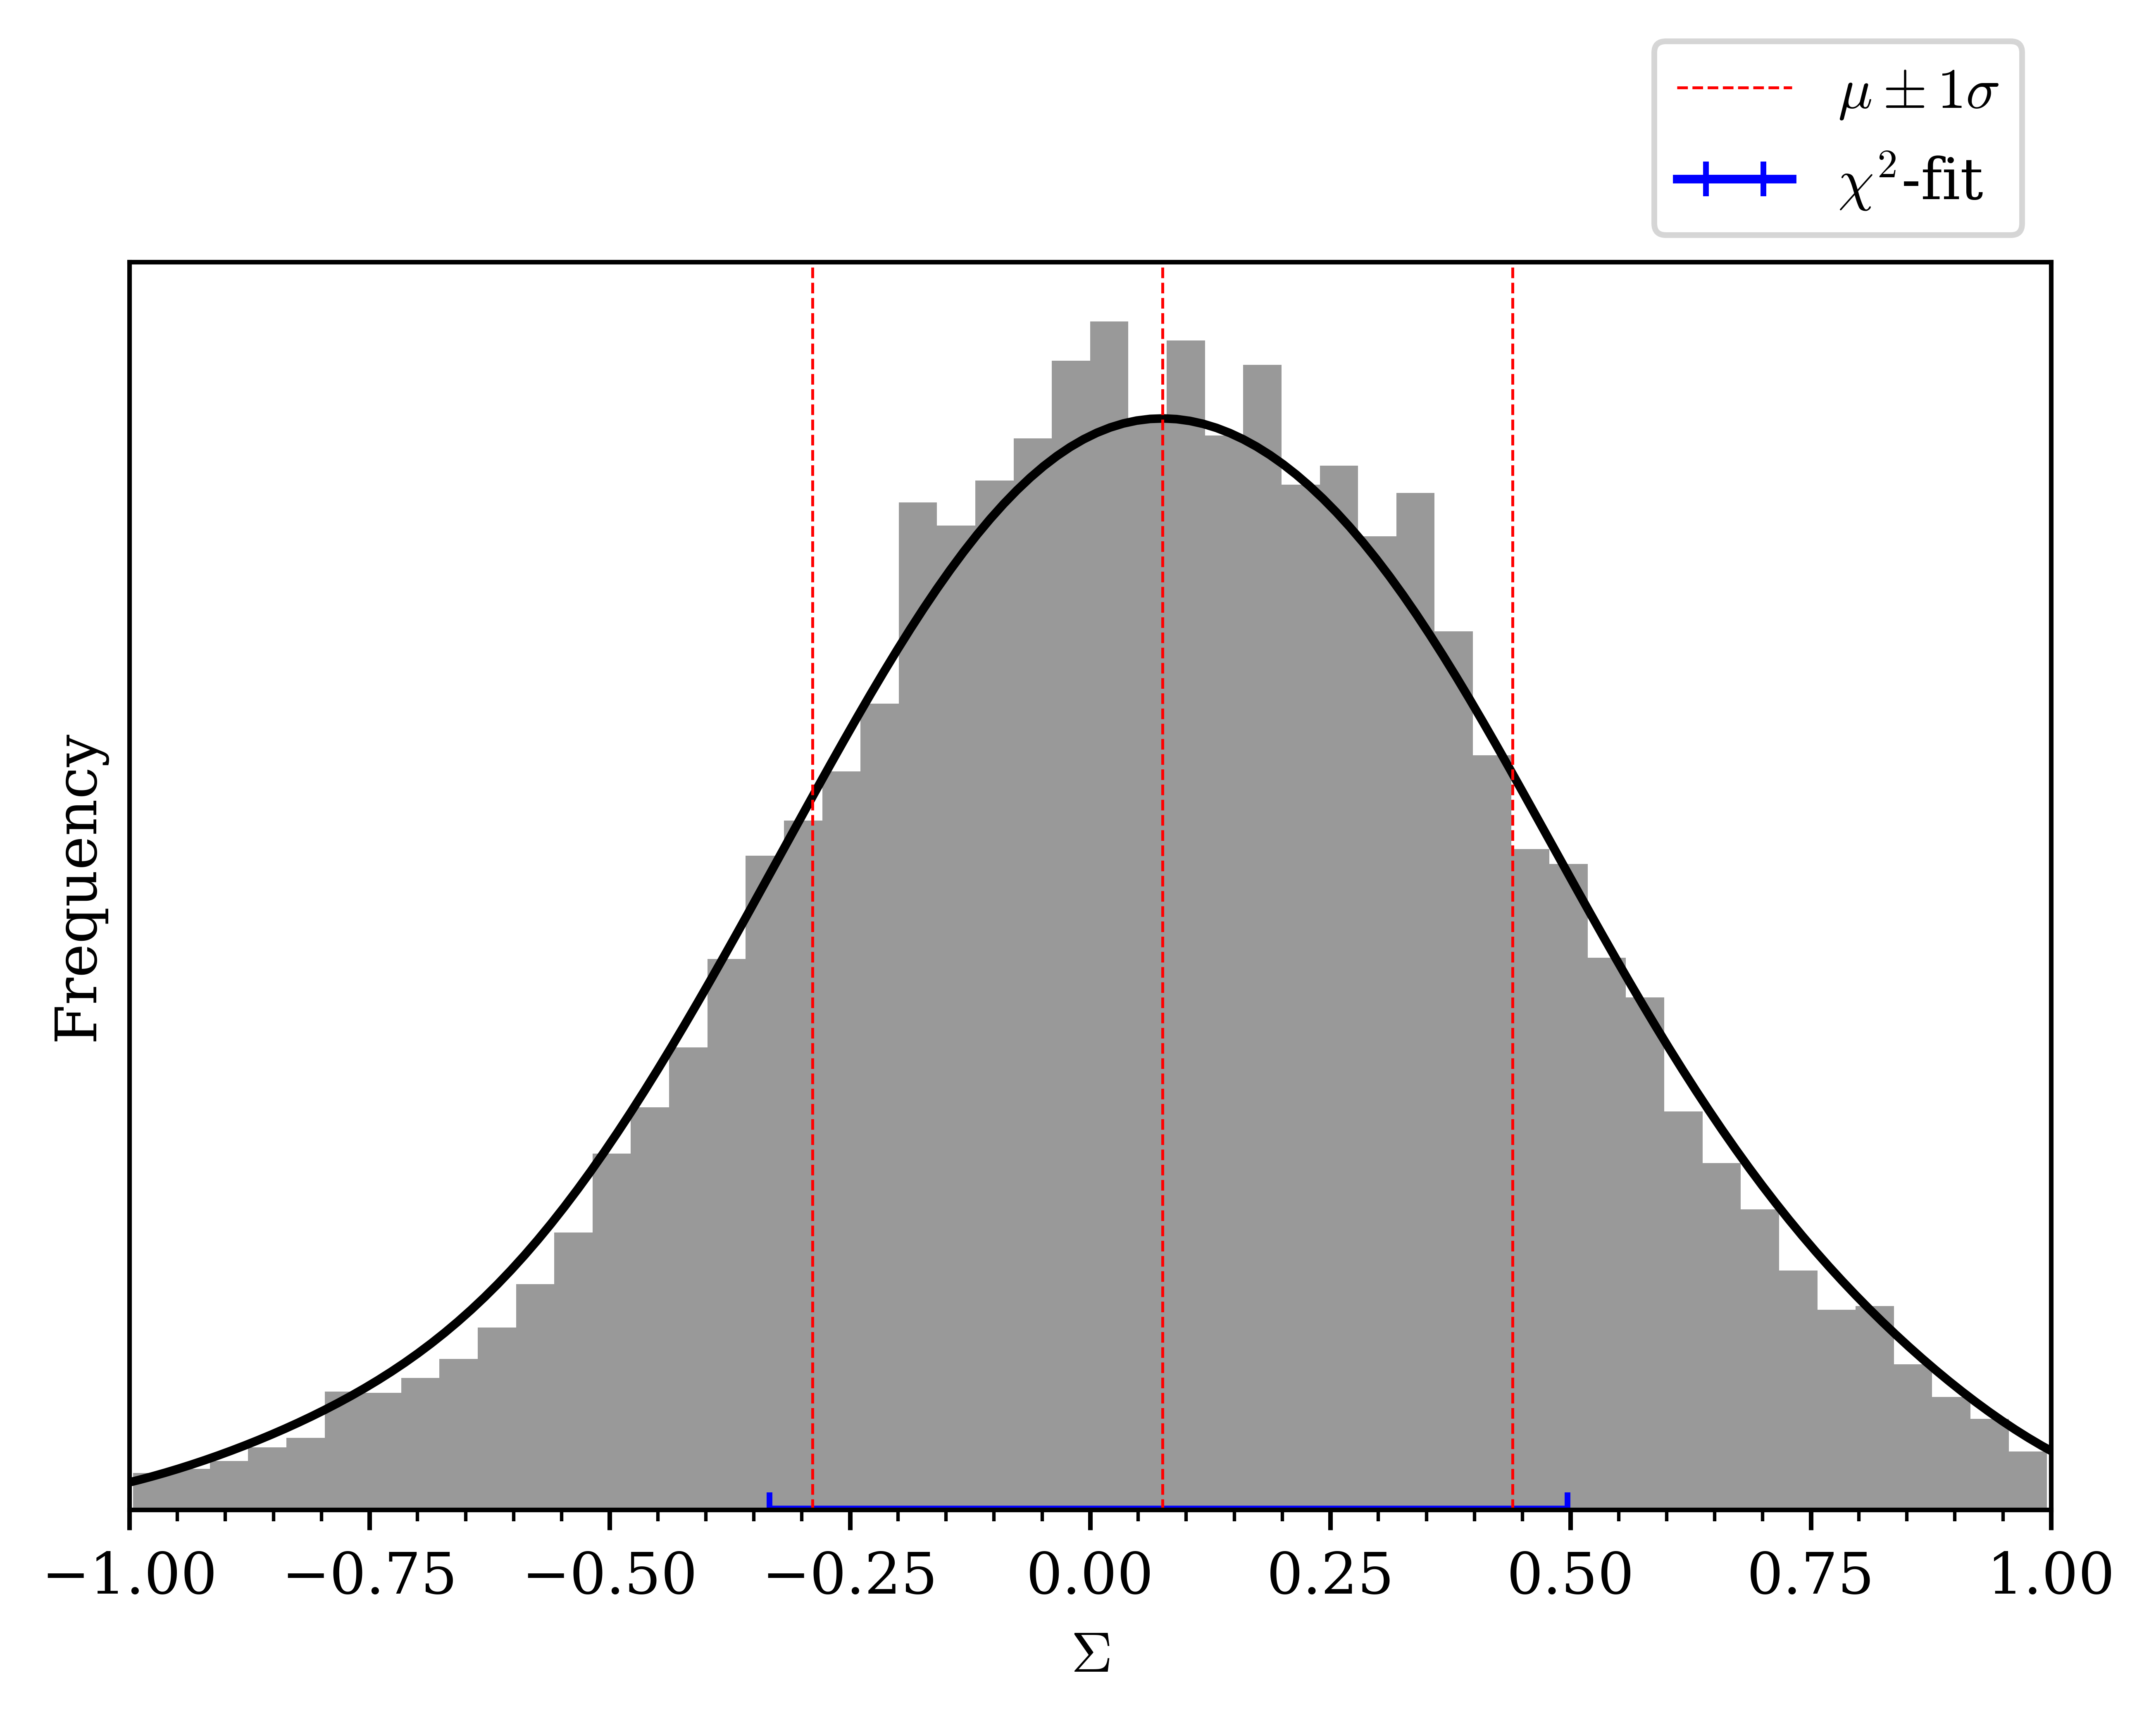

In [5]:
cols=[f'ebin{i:02d}costbin{j:02d}' for i in range(11) for j in range(12)]
index=['sigma_median','mcse','rhat']
for i in range(12):
    index.append(f'pval{i:02d}')
diagnostics_df=pd.DataFrame(columns=cols,index=index)
sigma_df=pd.DataFrame(columns=cols)
sigma_chi2_df=pd.DataFrame(columns=cols,index=['sigma','error'])
for i in range(0,1):# 11 energy bins
    #fig, ax = plt.subplots(3,4,sharex='col',sharey='row')
    plt.subplots_adjust(hspace=0,wspace=0)
    sigma_list=[]
    chi2_sigma_list=[]
    chi2_sigma_err_list=[]
    for j in range(0,1): # 12 bins in costheta
        #read in the data
        df_tmp=final_df[['phi',f'A_{i,j}',f'dA_{i,j}']]
        df_tmp=df_tmp.rename(columns={'phi': 'x', f'A_{i,j}': 'y', f'dA_{i,j}': 'dy'})
        #fit with mcmc and get samples
        fit=bayesian_fit(data=df_tmp,stanfile='stan_file.stan',nsamples=5000)
        sigma=fit.samples_df()['a']
        #write results
        currbin=f"ebin{i:02d}costbin{j:02d}"
        sigma_df[currbin]=sigma
        #write chi2 results
        popt, pcov = fit.get_chisqpars(fit.f)
        sigma_chi2_df[currbin]=[popt[0],np.sqrt(pcov[0][0])]
        #get fit diagnostics, i.e. pvalue
        pvalue=fit.pval()
        #get mcmc diagnostics, i.e. r_hat and median+mcse
        summary=fit.fitobj.summary()
        median=(summary['50%']['a'])
        mcse=(az.mcse(np.transpose(fit.fitobj.draws(concat_chains=False)[:,:,7]),method='median'))
        rhat=(summary['R_hat']['a'])
        dlist=[median,mcse,rhat]
        dlist.extend(pvalue)
        #write diagnostics
        diagnostics_df[currbin]=dlist

        fit.plot_posterior(params=['a'],func=fit.f,save=True)
        plt.show()
        #fit.plot_ppd(save=True,i=i,j=j,display=False,fitfunc=fit.f,width=50)
#diagnostics_df.to_csv('diagnostics.csv')

#sigma_df.to_csv('sigma.csv')
#sigma_chi2_df.to_csv('sigma_chi2.csv')


In [39]:
[sigma_chi2_df[f"ebin01costbin{j:02d}"]['sigma'] for j in range(12)]

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [42]:
sigma_df=pd.read_csv('sigma.csv',index_col=0)
sigma_chi2_df=pd.read_csv('sigma_chi2.csv',index_col=0)

sigma_chi2_df

,ebin00costbin00,ebin00costbin01,ebin00costbin02,ebin00costbin03,ebin00costbin04,ebin00costbin05,ebin00costbin06,ebin00costbin07,ebin00costbin08,ebin00costbin09,...,ebin10costbin02,ebin10costbin03,ebin10costbin04,ebin10costbin05,ebin10costbin06,ebin10costbin07,ebin10costbin08,ebin10costbin09,ebin10costbin10,ebin10costbin11
sigma,0.081557,-0.029408,0.281508,0.142804,0.401417,0.804479,0.841464,0.832474,0.704406,0.701994,...,0.484651,0.127603,-0.092683,0.008497,0.207725,0.569613,0.694732,0.884711,0.859071,0.495717
error,0.415215,0.347677,0.366327,0.286109,0.176210,0.146995,0.155579,0.169424,0.182647,0.155883,...,0.102594,0.135771,0.130078,0.127069,0.107664,0.122089,0.124483,0.088443,0.062580,0.058078


In [17]:
fig,ax = plt.subplots(4,3,sharex='col',sharey='row',dpi=1000,figsize=(10,7))
plt.subplots_adjust(wspace=0, hspace=0)
fig.delaxes(ax[3,2]) #The indexing is zero-based here
ax[2,2].get_xaxis().set_visible(True)
ax[2,2].xaxis.set_tick_params(which='both', labelbottom=True)
farahs_data=pd.read_csv('./Sigma_eta_datapoints_final_newsyserrorcalc.txt',sep=' ',header=None)
farahs_data.columns=['W','egamma','costheta','sigma','stat_error','sys_error','idk']
sigma_df=pd.read_csv('sigma.csv',index_col=0)
sigma_chi2_df=pd.read_csv('sigma_chi2.csv',index_col=0)

counter=0
for i in range(4):
    for j in range(3):
        if(j==0 and i==0):
            ax[i][j].set_ylabel('$\Sigma$')
        if(j>0 and (i==2 or i==3)):
            ax[i][j].set_xlabel('$\cos\\theta_{\eta}^{\mathrm{CMS}}$')
        ax[i][j].set_xlim([-1.2,1.2])
        ax[i][j].set_ylim([-1.5,1.5])
        if(counter<11):
            ax[i][j].errorbar(x=np.arange(-1,1,2/12),y=[sigma_chi2_df[f"ebin{counter:02d}costbin{j:02d}"]['sigma']for j in range(12)],
                              yerr=[sigma_chi2_df[f"ebin{counter:02d}costbin{j:02d}"]['error'] for j in range(12)],fmt='s',color="peachpuff",markersize=4.,label='$\chi^2 - fit$')
            ax[i][j].errorbar(x=np.arange(-1,1,2/12),y=farahs_data['sigma'][counter*12:counter*12+12],
                              yerr=farahs_data['stat_error'][counter*12:counter*12+12],fmt='v',color='darkorange',markersize=4.,label='[Afzal et al., 2020]')
            vp=ax[i][j].violinplot([sigma_df[f"ebin{counter:02d}costbin{j:02d}"] for j in range(12)],np.arange(-1,1,2/12),
                         showmeans=False, showextrema=False, showmedians=False,widths=0.3)
            ax[i][j].text(0,-1,f'${1130+counter*60}$ MeV $\leq E_\gamma < {1130+(counter+1)*60}$ MeV',fontsize=14,ha='center',va='center')
            #cosmetics
            for b in vp['bodies']:
                # get the center
                m = np.mean(b.get_paths()[0].vertices[:, 0])
                # modify the paths to not go further right than the center
                b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
                b.set_alpha(.5)
                b.set_color('blue')
        counter+=1
lines,labels = ax[0][0].get_legend_handles_labels() 
patch = mpatches.Patch(color='blue', label='bayesian fit',alpha=.5)
lines.append(patch)
plt.legend(handles=lines,bbox_to_anchor=(2.6,0.4))        
plt.show()
fig.savefig(f'./sigma_eta_alt.pdf',format='pdf',bbox_inches='tight',dpi=1000)


In [7]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(rhat_list)),rhat_list,'.')
ax.set_xlabel('Fit Nr.')
ax.set_ylabel('$\hat{R}$')
plt.show()
plt.savefig('rhat_alt.pdf')

NameError: name 'rhat_list' is not defined

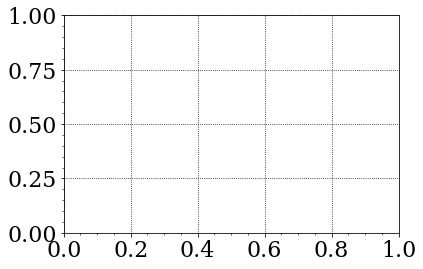

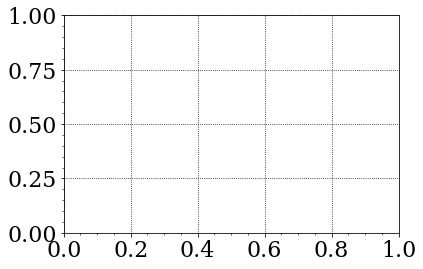

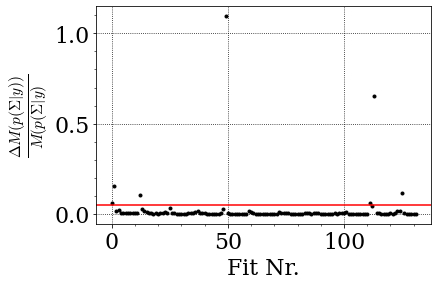

In [18]:
fig, ax = plt.subplots()
ax.plot(np.arange(132),np.abs(np.array(diagnostics_df.loc[['mcse']])[0]/np.array(diagnostics_df.loc[['sigma_median']])[0]),'.')
ax.set_xlabel('Fit Nr.')
ax.set_ylabel('$\\frac{\Delta M(p(\Sigma|y))}{M(p(\Sigma|y)}$')
#ax.set_ylim([0,0.5])
ax.axhline(y=0.05,color='red')
plt.show()
#plt.savefig('median_mcse_alt.pdf')

In [17]:
np.array(diagnostics_df.loc[['mcse']])[.shape

AttributeError: module 'numpy' has no attribute 'flat'

In [ ]:
farahs_data=pd.read_csv('./Sigma_eta_datapoints_final_newsyserrorcalc.txt',sep=' ',header=None)
farahs_data.columns=['W','egamma','costheta','sigma','stat_error','sys_error','idk']

In [ ]:
farahs_data['sigma'][24:24+12]

In [ ]:
diagnostics_df